# Preprocessing

Preprocessing is a crucial step. The goal is to convert the tweets to a list of embeddings :

```
["my", "tweet", "aha"]
```

becomes

    [<embedding of "my" shape (20,)>, <embedding of "tweet" shape (20,)>, <embedding of "aha" shape (20,)>]

Since we have 3 representation for each tweet (original, stemmed and lemmatized), we have to do this 3 times, and then merge the result. 

Since all tweets do not have the same length, we select empirically a fixed size of a tweet, and apply a 0-padding to shorter tweets.

Moreover, for limited memory reasons, the dataset is splitted in 15 blocs of data. 

This way, we obtain a shape of `(<block_size>, 3, <len_tweet>, <embedding_size>)`.

In [2]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import math
import matplotlib.pyplot as plt

#### Load the data

Change the `SET` variable to one of `{"", "stemmed", "lemmatized"}`.

In [3]:
PREFIX = ""
SET="stemmed"
EMBEDDINGS = PREFIX+"tweet_embeddings/embeddings_"+SET+".txt"
VOCAB = PREFIX+"tweet_embeddings/vocab_"+SET+".txt"

POS_TWEETS = PREFIX+"tweet_embeddings/train_pos_full_"+SET+".txt"
NEG_TWEETS = PREFIX+"tweet_embeddings/train_neg_full_"+SET+".txt"
TEST_DATA = PREFIX+"tweet_embeddings/test_data_"+SET+".txt"

# parse embeddings
vecs = {}
with open(EMBEDDINGS, "r") as f:
    for line in f:
        pline = line.rstrip().split(' ')
        word = pline[0]
        vecs[word] = np.array([float(x) for x in pline[1:]])

# parse vocabulary and build an index
with open(VOCAB, "r") as f:
    vocab = {x.rstrip().split(' ')[0]: i for i,x in enumerate(f)}
EMBEDDING_SIZE = len(vecs[list(vecs.keys())[0]])
embeddings = np.zeros((len(vocab), EMBEDDING_SIZE))
for w, v in vecs.items():
    if w == "<unk>":
        continue
    embeddings[vocab[w], :] = v


In [4]:
len_tweets = []
def load_from_file(filename, max_length_tweets):
    tweet_list = []
    with open(filename, "r") as f:
        for line in f:
            tweet = line.rstrip().split()
            l_tweet = len(tweet)
            tweet_list.append(tweet)
            if l_tweet > max_length_tweets:
                #print(f"{l_tweet}: {tweet}")
                max_length_tweets = len(tweet)
            len_tweets.append(l_tweet)
    return tweet_list, max_length_tweets

max_length_tweets = -1
p_tweets, max_length_tweets = load_from_file(POS_TWEETS, max_length_tweets)
n_tweets, max_length_tweets = load_from_file(NEG_TWEETS, max_length_tweets)
N = len(n_tweets) + len(p_tweets)
print(f"Loaded {N} tweets (max len {max_length_tweets})")

Loaded 2500000 tweets (max len 128)


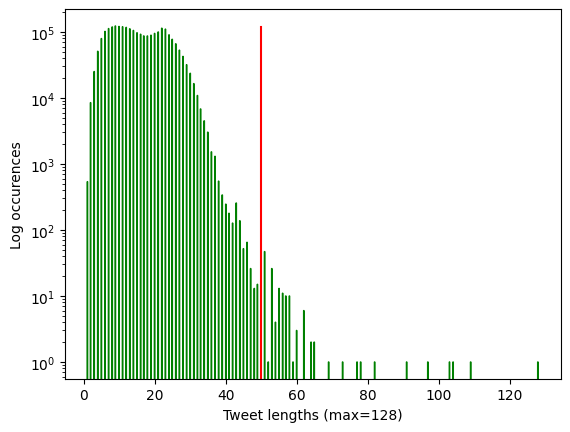

In [17]:
# We see that tweets that have a length over 40-60 are very rare.
counts, bins = np.histogram(len_tweets, bins=1000)
plt.xlabel(f"Tweet lengths (max={max_length_tweets})")
plt.plot([50] * 100, np.linspace(0, 120000, 100), c='r')
plt.yscale("log")
plt.ylabel("Log occurences")
plt.stairs(counts, bins, color='g')
plt.savefig("tweet_length_cutoff.png")

In [ ]:
# We thus drop all of them and adjust our max tweet length to avoid memory explosion
truncated_length = 50
max_length_tweets = truncated_length
p_tweets = [t for t in p_tweets if len(t) <= truncated_length]
n_tweets = [t for t in n_tweets if len(t) <= truncated_length]
if len(p_tweets) != len(n_tweets):
    print(f"Dropping a few more tweets to equalize lengths ({len(p_tweets)} != {len(n_tweets)})")
    min_length = min(len(p_tweets), len(n_tweets))
    if len(p_tweets) == min_length:
        n_tweets = n_tweets[:min_length]
    else:
        p_tweets = p_tweets[:min_length]
old_N_tweets = N
N = (len(p_tweets) + len(n_tweets))
print(f"Dropped {old_N_tweets - N} tweets of length > {truncated_length}")
print(f"Total is now {N} tweets (+: {len(p_tweets)}, -: {len(n_tweets)})")

Dropping a few more tweets to equalize lengths (1249918 != 1249935)
Dropped 164 tweets of length > 50
Total is now 2499836 tweets (+: 1249918, -: 1249918)


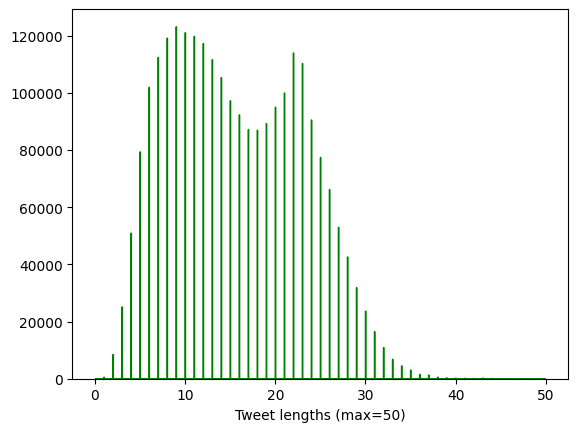

In [ ]:
counts, bins = np.histogram(len_tweets, bins=1000, range=(0, truncated_length))
plt.xlabel(f"Tweet lengths (max={max_length_tweets})")
plt.stairs(counts, bins, color='g')

In [ ]:
testing_tweets = []
testing_tweets_ids = []
with open(TEST_DATA, "r") as f:
    for line in f:
        parsed_line = line.rstrip().split(',')
        tweet = ','.join(parsed_line[1:]).split()
        testing_tweets.append(tweet)
        testing_tweets_ids.append(int(parsed_line[0]))


In [ ]:
def modified_load_tweets(tweets_list, tensor, start_idx, max_tweet_length, label=None ):
    print("Loading tweets...")
    i = 0
    tot = len(tweets_list)

    vocab_keys = set(vocab.keys())
    for tweet in tweets_list:
        if i % 5000 == 0 or i == tot-1:
            print(f"{i}/{tot} ({int(i/tot*100)} %)")

       # Filter out words not in the vocabulary
        tweet_filtered = [word for word in tweet if word in vocab_keys]

        embeddings_list_torch = torch.FloatTensor(np.array([embeddings[vocab[word]] for word in tweet_filtered]))

        length_tweet=len(tweet_filtered)

        diff_length=max_tweet_length - length_tweet

        if length_tweet == 0:
            tweet_embeddings = torch.zeros((max_tweet_length, len(vecs[list(vecs.keys())[0]])))
        else:
           tweet_mean = torch.mean(embeddings_list_torch, axis=0)
           tweet_embeddings = torch.ones((max_tweet_length, len(vecs[list(vecs.keys())[0]])))*tweet_mean # to have all tweets of shape (#tweets, max_tweet_len, 20)
           middle = diff_length//2
           if (diff_length%2==0):
               tweet_embeddings[middle:max_tweet_length-middle,:] = embeddings_list_torch #putting them in the middle to do some kind of padding
           else:
               tweet_embeddings[middle:(max_tweet_length-(middle+1)),:] = embeddings_list_torch
        if label is not None:
            tweet_embeddings = torch.vstack((tweet_embeddings, label*torch.ones(EMBEDDING_SIZE,)))

        tensor[start_idx+i] = tweet_embeddings
        i += 1
    return tensor

#### Save back the intermediate blocs to disk

We use the `input/cnn/` directory.

In [ ]:
def save_train(torch_series_train, max_tot, batch_n=''):
    SAVE_PREFIX = PREFIX + "input/cnn/"
    SUFFIX = '_'+str(batch_n)+'_full_'+SET+'.pt'

    X = torch_series_train[:,:-1]
    y = torch_series_train[:,-1][:,0]
    RANDOM_SEED = 1234

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
    torch.save(X_train, SAVE_PREFIX+'X_train_cnn_new'+SUFFIX)
    torch.save(X_test, SAVE_PREFIX+'X_test_cnn_new'+SUFFIX)
    torch.save(y_train, SAVE_PREFIX+'y_train_cnn_new'+SUFFIX)
    torch.save(y_test, SAVE_PREFIX+'y_test_cnn_new'+SUFFIX)
    print("TRAINING Saved : \n"+'\n'.join([SAVE_PREFIX+'X_train_cnn_new'+SUFFIX,SAVE_PREFIX+'X_test_cnn_new'+SUFFIX,SAVE_PREFIX+'y_train_cnn_new'+SUFFIX,SAVE_PREFIX+'y_test_cnn_new'+SUFFIX]))

def save_test(torch_series_test):
    SAVE_PREFIX = PREFIX + "input/cnn/"
    torch.save(torch_series_test, SAVE_PREFIX+'X_T_'+SET+'.pt')
    print("TESTING Saved : \n"+SAVE_PREFIX+'X_T_'+SET+'.pt')


In [ ]:
test_max_length_tweets = max(len(tweet) for tweet in testing_tweets)
assert test_max_length_tweets <= max_length_tweets,  f"There are testing tweets that are longer than {truncated_length} !"
max_tot=max(test_max_length_tweets, max_length_tweets)
print(max_tot)

50


In [ ]:
assert len(p_tweets) == len(n_tweets), "To simplify please make them have the same length"
indices = np.arange(len(p_tweets))
wanted_batch_size = 80000
n_batches = int((N/2)//wanted_batch_size) # N/2 because n_tweets AND p_tweets
print(f"n_batches={n_batches}")
indices_split = np.array_split(indices, n_batches)
print(f"Batch sizes: {[len(a) for a in indices_split]}")

n_batches=15
Batch sizes: [83328, 83328, 83328, 83328, 83328, 83328, 83328, 83328, 83328, 83328, 83328, 83328, 83328, 83327, 83327]


In [ ]:
%%time
for idx, batch in enumerate(indices_split):
    if idx < 11:
        continue
    curr_batch_size = len(batch)
    start = batch[0]
    stop = batch[-1]
    print(f"Processing batch {idx+1}/{n_batches}: [{start},{stop+1}], size={curr_batch_size}")
    series_train = torch.zeros((curr_batch_size*2, max_tot+1, EMBEDDING_SIZE)) # +1 for label
    print(f"Current tensor shape = {series_train.shape}")
    series_train = modified_load_tweets(p_tweets[start:stop+1], series_train, 0, max_tot, 1)
    series_train = modified_load_tweets(n_tweets[start:stop+1], series_train, curr_batch_size, max_tot, -1)
    save_train(series_train, max_tot, idx)
    del series_train

Processing batch 12/15: [916608,999936], size=83328
Current tensor shape = torch.Size([166656, 51, 20])
Loading tweets...
0/83328 (0 %)
5000/83328 (6 %)
10000/83328 (12 %)
15000/83328 (18 %)
20000/83328 (24 %)
25000/83328 (30 %)
30000/83328 (36 %)
35000/83328 (42 %)
40000/83328 (48 %)
45000/83328 (54 %)
50000/83328 (60 %)
55000/83328 (66 %)
60000/83328 (72 %)
65000/83328 (78 %)
70000/83328 (84 %)
75000/83328 (90 %)
80000/83328 (96 %)
83327/83328 (99 %)
Loading tweets...
0/83328 (0 %)
5000/83328 (6 %)
10000/83328 (12 %)
15000/83328 (18 %)
20000/83328 (24 %)
25000/83328 (30 %)
30000/83328 (36 %)
35000/83328 (42 %)
40000/83328 (48 %)
45000/83328 (54 %)
50000/83328 (60 %)
55000/83328 (66 %)
60000/83328 (72 %)
65000/83328 (78 %)
70000/83328 (84 %)
75000/83328 (90 %)
80000/83328 (96 %)
83327/83328 (99 %)
TRAINING Saved : 
/content/drive/MyDrive/Colab Notebooks/batches/small/X_train_cnn_new_11_full_stemmed.pt
/content/drive/MyDrive/Colab Notebooks/batches/small/X_test_cnn_new_11_full_stemmed.

In [ ]:
# no label since this is the prediction set
series_test = torch.zeros((len(testing_tweets), max_tot, EMBEDDING_SIZE))
series_test = modified_load_tweets(testing_tweets, series_test, 0, max_tot)
save_test(series_test)

Loading tweets...
0/10000 (0 %)
5000/10000 (50 %)
9999/10000 (99 %)
TESTING Saved : 
/content/drive/MyDrive/Colab Notebooks/batches/small/X_T_stemmed.pt


In [ ]:
# test load a batch
y_train_1 = torch.load(PREFIX+"batches/small/y_train_cnn_new_1_full_lemmatized.pt")

In [ ]:
print(y_train_1.shape)
y_train_1

torch.Size([116659])


tensor([ 1.,  1.,  1.,  ...,  1., -1., -1.])

## Merge the 3 datasets in a single 3-channels bloc

We now want to convert 3 tensors of shape `(<bloc_size>, 50, 20)` in a single tensor of shape `(<bloc_size>, 3, 50, 20)`.

In [ ]:
PREFIX = "input/cnn/"

MATRICES = ["X_train", "X_test"]
SUFFIXES = [".pt", "_stemmed.pt", "_lemmatized.pt"]

for mat in MATRICES:
    for i in range(15):  # n batches
        print(f"Merging for {PREFIX}{mat}_cnn_new_{i}_full")
        X_1 = torch.load(f"{PREFIX}{mat}_cnn_new_{i}_full{SUFFIXES[0]}")
        X_2 = torch.load(f"{PREFIX}{mat}_cnn_new_{i}_full{SUFFIXES[1]}")
        X_3 = torch.load(f"{PREFIX}{mat}_cnn_new_{i}_full{SUFFIXES[2]}")
        X_merged = torch.swapaxes(torch.stack((X_1, X_2, X_3), 0), 0, 1)
        print("Final shape", X_merged.shape)
        torch.save(X_merged, f"{PREFIX}{mat}_cnn_new_{i}_full_3CH.pt")

In [ ]:
MATRICE = "X_T"
SUFFIXES = [".pt", "_stemmed.pt", "_lemmatized.pt"]

print(f"Merging for {PREFIX}{MATRICE}")
X_1 = torch.load(f"{PREFIX}{MATRICE}{SUFFIXES[0]}")
X_2 = torch.load(f"{PREFIX}{MATRICE}{SUFFIXES[1]}")
X_3 = torch.load(f"{PREFIX}{MATRICE}{SUFFIXES[2]}")
X_merged = torch.swapaxes(torch.stack((X_1, X_2, X_3), 0), 0, 1)
print("Final shape", X_merged.shape)
print(f"{PREFIX}{MATRICE}_3CH.pt")
torch.save(X_merged, f"{PREFIX}{MATRICE}_3CH.pt")

Merging for /content/drive/MyDrive/Colab Notebooks/batches/small/X_T
Final shape torch.Size([10000, 3, 50, 20])
/content/drive/MyDrive/Colab Notebooks/batches/small/X_T_3CH.pt


In [ ]:
ref = X_1[1]
print(ref)

tensor([[-0.5729,  0.0571, -1.1008, -0.6668,  0.0385, -2.1303,  0.5006,  0.4607,
         -1.7266, -0.1912,  0.1504,  0.3255,  0.1144,  0.6374, -0.6799, -0.3823,
         -0.0302, -0.0718, -0.3527, -1.6619],
        [-0.5729,  0.0571, -1.1008, -0.6668,  0.0385, -2.1303,  0.5006,  0.4607,
         -1.7266, -0.1912,  0.1504,  0.3255,  0.1144,  0.6374, -0.6799, -0.3823,
         -0.0302, -0.0718, -0.3527, -1.6619],
        [-0.5729,  0.0571, -1.1008, -0.6668,  0.0385, -2.1303,  0.5006,  0.4607,
         -1.7266, -0.1912,  0.1504,  0.3255,  0.1144,  0.6374, -0.6799, -0.3823,
         -0.0302, -0.0718, -0.3527, -1.6619],
        [-0.5729,  0.0571, -1.1008, -0.6668,  0.0385, -2.1303,  0.5006,  0.4607,
         -1.7266, -0.1912,  0.1504,  0.3255,  0.1144,  0.6374, -0.6799, -0.3823,
         -0.0302, -0.0718, -0.3527, -1.6619],
        [-0.5729,  0.0571, -1.1008, -0.6668,  0.0385, -2.1303,  0.5006,  0.4607,
         -1.7266, -0.1912,  0.1504,  0.3255,  0.1144,  0.6374, -0.6799, -0.3823,
      

In [ ]:
torch.all(torch.eq(ref, torch.stack((X_1, X_2, X_3), 0)[0][1]))

tensor(True)

This is to test that the transformation applied correctly.

In [ ]:
transformed = torch.swapaxes(torch.stack((X_1, X_2, X_3), 0), 0, 1)
torch.all(torch.eq(ref, transformed[1][0]))

tensor(True)

The dataset is now ready for use ! The files we are interested in are the following :


```bash
input/cnn/
├── X_T_3CH.pt  # this holds the unlabeled data we have to predict
├── X_test_cnn_new_{0-15}_full_3CH.pt
├── X_train_cnn_new_{0-15}_full_3CH.pt
├── y_test_cnn_new_{0-15}_full.pt
└── y_train_cnn_new_{0-15}_full.pt
```
